# Part 2. Model Training & Evaluation - RNN

## Prepare embedding matrix and metadata

In [7]:
import json
from pathlib import Path

import numpy as np

embedding_path = Path("models/embedding_matrix.npy")
index_from_word_path = Path("models/index_from_word.json")

embedding_matrix = np.load(embedding_path)
with index_from_word_path.open() as f:
    index_from_word = json.load(f)

## Prepare dataset

In [ ]:
from utils.text import tokenize
from datasets import load_dataset

dataset = load_dataset("rotten_tomatoes")
train_dataset = tokenize(dataset["train"])
val_dataset = tokenize(dataset["validation"])
test_dataset = tokenize(dataset["test"])

In [16]:
from utils.text import token_to_index

train_dataset = token_to_index(dataset=train_dataset, index_from_word=index_from_word)
val_dataset = token_to_index(dataset=val_dataset, index_from_word=index_from_word)
test_dataset = token_to_index(dataset=test_dataset, index_from_word=index_from_word)

In [17]:
train_dataset = train_dataset.select_columns(["label", "original_len", "indexes"])
val_dataset = val_dataset.select_columns(["label", "original_len", "indexes"])
test_dataset = test_dataset.select_columns(["label", "original_len", "indexes"])

In [18]:
train_dataset.set_format(type="torch")
val_dataset.set_format(type="torch")
test_dataset.set_format(type="torch")

In [24]:
train_dataset

Dataset({
    features: ['label', 'original_len', 'indexes'],
    num_rows: 8530
})

## Train RNN Model

In [164]:
SEARCH_SPACE = {
    "batch_size": [32, 64, 128, 256, 512, 1024, 2048],
    "learning_rate": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    "optimizer_name": ["SGD", "Adagrad", "RMSprop", "Adam"],
    # RNN Model Parameters
    "hidden_dim": [256, 128, 64, 32],
    "num_layers": [1, 2, 4],
    "sentence_representation_type": ["last", "average", "max"],
}

In [ ]:
from utils.train import train_rnn_model_with_parameters

for hidden_dim in SEARCH_SPACE["hidden_dim"]:
    for num_layers in SEARCH_SPACE["num_layers"]:
        for optimizer_name in SEARCH_SPACE["optimizer_name"]:
            for batch_size in SEARCH_SPACE["batch_size"]:
                for learning_rate in SEARCH_SPACE["learning_rate"]:
                    for sentence_representation_type in SEARCH_SPACE["sentence_representation_type"]:
                        log_message = f"---------- batch_size_{batch_size}; lr_{learning_rate}; optimizer_{optimizer_name}; hidden_dim_{hidden_dim}; num_layers_{num_layers}; sentence_representation_{sentence_representation_type}  ----------"
                        print(log_message)
                        train_rnn_model_with_parameters(
                            embedding_matrix=embedding_matrix,
                            train_dataset=train_dataset,
                            val_dataset=val_dataset,
                            batch_size=batch_size,
                            learning_rate=learning_rate,
                            optimizer_name=optimizer_name,
                            hidden_dim=hidden_dim,
                            num_layers=num_layers,
                            sentence_representation_type=sentence_representation_type,
                            show_progress=True,
                        )

## Model Configurations Comparison

In [58]:
from utils.analytics import load_tensorboard_logs

train_results_df = load_tensorboard_logs(log_dir="tb_logs")

In [60]:
train_results_df = train_results_df.sort_values(
    by=["val_acc"], ascending=False
).reset_index(drop=True)
train_results_df.head(20)

,val_acc,train_acc,batch_size,hidden_dim,learning_rate,optimizer_name,num_layers,sentence_representation_type,epoch,train_loss,val_loss,filename
0,0.790807,0.820573,2048,32,0.0100,Adam,2,max,13.0,0.391930,0.460857,events.out.tfevents.1730291095.yuriarch.189059...
1,0.788931,0.774444,2048,32,0.0010,Adam,2,max,29.0,0.479678,0.472255,events.out.tfevents.1730291029.yuriarch.189059...
2,0.787992,0.851648,2048,128,0.0010,Adam,1,max,25.0,0.383107,0.453145,events.out.tfevents.1730019019.yuriarch.111089...
3,0.785178,0.807840,2048,64,0.0010,Adam,1,max,28.0,0.403626,0.468708,events.out.tfevents.1730199044.yuriarch.294903...
4,0.783302,0.926294,2048,128,0.0010,Adam,2,max,29.0,0.254296,0.461375,events.out.tfevents.1730184433.yuriarch.15222.5
5,0.783164,0.939560,1024,128,0.0010,Adam,1,max,19.0,0.222143,0.452719,events.out.tfevents.1730017215.yuriarch.111089...
6,0.781426,0.782967,2048,128,0.0010,RMSprop,1,max,23.0,0.456223,0.457545,events.out.tfevents.1730013877.yuriarch.111089...
7,0.779550,0.809066,2048,128,0.0100,Adagrad,1,max,19.0,0.429106,0.459786,events.out.tfevents.1730008662.yuriarch.111089.67
8,0.778612,0.822040,2048,64,0.0010,RMSprop,1,max,22.0,0.382432,0.459123,events.out.tfevents.1730196305.yuriarch.294903...
9,0.776735,0.822485,2048,32,0.0010,Adam,1,max,44.0,0.397813,0.466809,events.out.tfevents.1730273042.yuriarch.1888.336


# (a) Final Configuration of best model

In [61]:
best_rnn_model_configuration = train_results_df.head(1)
best_rnn_model_configuration

,val_acc,train_acc,batch_size,hidden_dim,learning_rate,optimizer_name,num_layers,sentence_representation_type,epoch,train_loss,val_loss,filename
0,0.790807,0.820573,2048,32,0.01,Adam,2,max,13.0,0.39193,0.460857,events.out.tfevents.1730291095.yuriarch.189059...


In [12]:
from models.RNN import RNN

rnn_model = RNN(
    embedding_matrix=embedding_matrix,
    hidden_dim=32,
    output_dim=2,
    num_layers=2,
    sentence_representation_type="max",
)

In [13]:
from pathlib import Path


best_rnn_model_filename = best_rnn_model_configuration["filename"].item()
matched_files = list(Path().rglob(best_rnn_model_filename))

if not matched_files:
    print("Model checkpoint not found!")
else:
    checkpoint_dir = matched_files[0].parent / "checkpoints"
    checkpoint_files = (
        list(checkpoint_dir.glob("*.ckpt")) if checkpoint_dir.exists() else []
    )

    if not checkpoint_files:
        print("No checkpoint files found in the checkpoint directory!")
    else:
        best_checkpoint = checkpoint_files[0] 
        best_rnn_model = RNNClassifier.load_from_checkpoint(
            best_checkpoint, rnn_model=rnn_model
        )
        print(best_rnn_model)

RNNClassifier(
  (model): RNN(
    (embedding): Embedding(14687, 300)
    (rnn): RNN(300, 32, num_layers=2, batch_first=True)
    (fc): Linear(in_features=32, out_features=16, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=16, out_features=2, bias=True)
  )
  (metric): MulticlassAccuracy()
)


# (b) Accuracy on Testset

In [19]:
import lightning as L
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset, shuffle=True)

trainer = L.Trainer(accelerator="cpu")
trainer.test(best_rnn_model, test_dataloader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/yuri/sc4002-nlp-sentiment-classification/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/yuri/sc4002-nlp-sentiment-classification/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/yuri/sc4002-nlp-sentiment-classification/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1066/1066 [00:02<00:00, 473.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7889305949211121
        test_loss           0.46269166469573975
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.46269166469573975, 'test_acc': 0.7889305949211121}]

# (c) Strategies to derive final sentence representation

1. Last State: Use last hidden state as sentence representation
2. Max Pooling
3. Average Pooling

In [62]:
best_rnn_model_configuration

,val_acc,train_acc,batch_size,hidden_dim,learning_rate,optimizer_name,num_layers,sentence_representation_type,epoch,train_loss,val_loss,filename
0,0.790807,0.820573,2048,32,0.01,Adam,2,max,13.0,0.39193,0.460857,events.out.tfevents.1730291095.yuriarch.189059...


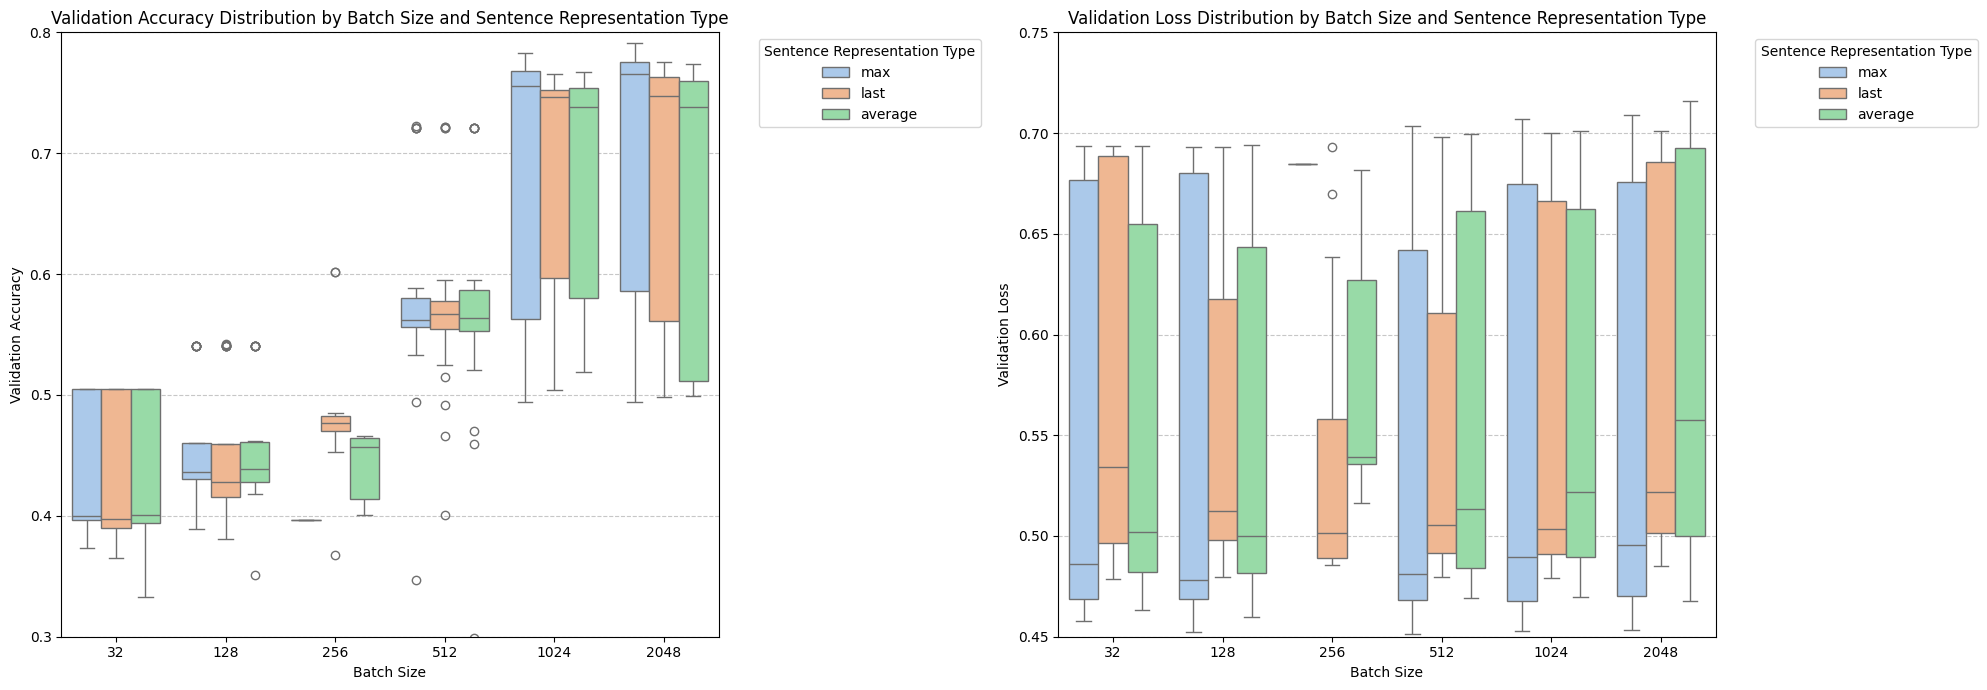

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt


filtered_df = train_results_df[
    (train_results_df["optimizer_name"] == "Adam")
][["val_acc", "val_loss", "batch_size", "sentence_representation_type"]]

legend_order = ["max", "last", "average"]

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
sns.boxplot(
    data=filtered_df,
    x="batch_size",
    y="val_acc",
    hue="sentence_representation_type",
    hue_order=legend_order,
    palette="pastel",
)
plt.title("Validation Accuracy Distribution by Batch Size and Sentence Representation Type")
plt.xlabel("Batch Size")
plt.ylabel("Validation Accuracy")
plt.ylim(0.3, 0.8)
plt.legend(title="Sentence Representation Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis="y", linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.boxplot(
    data=filtered_df,
    x="batch_size",
    y="val_loss",
    hue="sentence_representation_type",
    hue_order=legend_order,
    palette="pastel",
)
plt.title("Validation Loss Distribution by Batch Size and Sentence Representation Type")
plt.xlabel("Batch Size")
plt.ylabel("Validation Loss")
plt.ylim(0.45, 0.75)
plt.legend(
    title="Sentence Representation Type", bbox_to_anchor=(1.05, 1), loc="upper left"
)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()